<a href="https://colab.research.google.com/github/niemand-01/ML-Demo/blob/master/Kmeans_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import logging


In [5]:
Data,label = make_blobs(n_samples=100,n_features=2,centers=4)

# print(X)

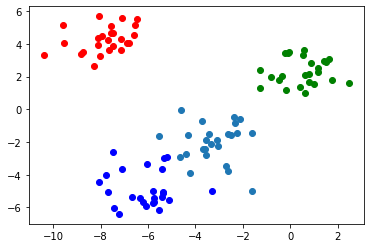

In [6]:
# X[y==0,0] means the corresponding X[i][0] when y[i]==0
plt.scatter(Data[label==0,0], Data[label==0,1])
plt.scatter(Data[label==1,0], Data[label==1,1], c='r')
plt.scatter(Data[label==2,0], Data[label==2,1], c='b')
plt.scatter(Data[label==3,0], Data[label==3,1], c='g')

# pytorch 简单总结

1. to(torch.device("cpu")) 分配tensor 给cpu/cuba
2. dim=1(row), 0(coloumn)
3. torch.empty() 内部为Null
4. torch.squeeze(a) 删除a所有dim里面的1
5. torch.unsqueeze(a,1) 添加1在a的dim里面index=1的地方，比如本来是(2,)==》(2,1)
6. torch.sum, torch.mul都支持broadcast
7. torch.cat([tensor1,tensor2,...],dim=1) 将tensor1,2...以dim=1(row)的形式连接起来

In [16]:
class Kmeans:
  def __init__(self,n_clusters=20,max_iter=None,verbose=True,device=torch.device("cpu")):
    self.n_cluster = n_clusters
    # number of clusters
    self.n_clusters = n_clusters
    self.labels = None
    # distance to center
    self.dists = None
    # center xy
    self.centers = None

    # assign this tensor to this device
    self.variation = torch.Tensor([float("Inf")]).to(device)
    self.verbose = verbose
    # start flag
    self.started = False
    self.representive_samples = None
    # max iteration 
    self.max_iter = max_iter
    self.count = 0
    # the device on which tensor will be allocated
    # options: cpu/cuda
    self.device = device

  def fit(self,x):

    x = torch.tensor(x)
    # randint(lowest integer to be drawn ,highest integer, size,)

    # randomly choose centers number of n_clusters
    init_row = torch.randint(0,x.shape[0],(self.n_clusters,)).to(self.device)
    init_points = x[init_row]
    self.centers = init_points

    while True:
      self.assign_to_center(x)
      self.update_center(x)

      if self.verbose:
        print(self.variation,torch.argmin(self.dists,(0)))

      # max iter is not given, ending with small variation
      if torch.abs(self.variation) <1e-3 and self.max_iter is None:
        break
      # max iter is given
      elif self.max_iter is not None and self.count == self.max_iter:
        break

      self.count += 1

    #self.representive_samples()
    return self.labels

  def assign_to_center(self,x):
    # create label placeholders --> long type --> assign to "cpu"
    labels = torch.empty((x.shape[0],)).long().to(self.device)
    # distances place holder (0,2) --> assign to "cpu"
    dists = torch.empty((0,self.n_clusters)).to(self.device)

    # (index,value)
    for i,sample in enumerate(x):
      # calculate distance from each sample to centers
      # sum of each row and return in the given dimension (1:row,0:column)
      # dist kind of type [[(x-c1x)^2+(y-c1y)^2],[(x-c2x)^2+(y-c2y)^2]]
      # sample-self.centers is broadcasted into self.centers dimension

      disQ = torch.tensor(sample-self.centers)
      dist = torch.sum(torch.mul(disQ,disQ),(1))
      # label is the argmin of dist
      labels[i] = torch.argmin(dist)

      # unsqueeze into dim=1(row),0(column)
      # concatenate tensors (of same shape) into dimension=1(row),0(column)
      dists = torch.cat([dists, dist.unsqueeze(0)], (0))
    self.labels = labels
    if self.started:
      # self.dists will be broadcast into dim of dists
      self.variation = torch.sum(self.dists - dists)
      self.dists = dists
      self.started = True

  def update_center(self, x):
    # placeholder for new centers (x,y)
    centers = torch.empty((0, x.shape[1])).to(self.device)
    
    for i in range(self.n_clusters):
      mask = self.labels == i
      cluster_samples = x[mask]
      # torch.cat like append function, 
      centers = torch.cat([centers, torch.mean(torch.tensor(cluster_samples), (0)).unsqueeze(0)], (0))
    self.centers = centers

  def sample_closest_dist(self):
    # argmin(input,dimension)
    self.representative_samples = torch.argmin(self.dists, (0))



km = Kmeans(n_clusters=3,max_iter=10,verbose=False)
labels = km.fit(Data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


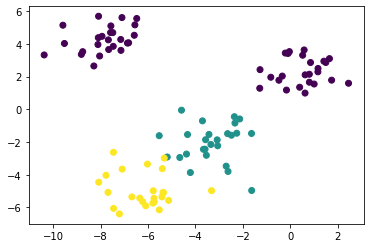

In [14]:
# visualize
plt.scatter(Data[:,0],Data[:,1],c=labels,cmap='viridis')